In [1]:
import sys

print("--sys.version—")
print(sys.version)

--sys.version—
3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 06:05:16) 
[Clang 12.0.1 ]


### 이미지 데이터 train, test, vaild 나누기 

In [2]:
import tensorflow as tf
tf.__version__

'2.8.0'

In [3]:
# 훈련 검증, 테스트 폴더로 이미지 복사 
import os, shutil
original_dataset_dir = './input_folders/'

folder_list = []
for path_ in os.listdir(original_dataset_dir):
    if path_.startswith('.'):
        pass
    else:
        path2 = original_dataset_dir + path_
        folder_list.append(path_)
        
print(folder_list)

plant_cnt = {}
for path in folder_list:
    plant_cnt[path] = len(os.listdir(original_dataset_dir+path))
    
print(plant_cnt)

In [4]:
base_dir = './datasets/' 
# os.mkdir(base_dir)
base_dir = './datasets/Plant' # 소규모 데이터셋 저장할 디렉토리
# os.mkdir(base_dir)

In [5]:
# 이미지 데이터 이름 변경 (순서매기기)
for path in folder_list:
    i = 1
    for imgPath in os.listdir(original_dataset_dir+path):
        src = os.path.join(original_dataset_dir+path, imgPath)
        dst_ = path + '_' + str(i) + '.png'
        dst = os.path.join(original_dataset_dir+path, dst_)
        
        print(src)
        print(dst)
        print('-' * 40)
        
        os.rename(src, dst)
        i += 1

In [6]:
import os
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

# os.mkdir(train_dir)
# os.mkdir(valid_dir)
# os.mkdir(test_dir)

In [7]:
data_list = [train_dir, valid_dir, test_dir]

for dataset in data_list:
    print('dataset : ',dataset)
    for plant in plant_cnt:
        filePath_ = os.path.join(dataset, plant)
        os.mkdir(filePath_)

        # 데이터 개수의 반틈 train 폴더에 복사
        if dataset == data_list[0]:
            cnt = int(int(plant_cnt[plant])/2)
            fnames = ['{}_{}.png'.format(plant, i+1) for i in range(0,cnt)]
            print(cnt)
            print(plant,'- train_dir len :', len(fnames))
        
        elif dataset == data_list[1]:
            cnt = int(int(plant_cnt[plant])/2)
            cnt3 = int((int(plant_cnt[plant])/4)*3)
            fnames = ['{}_{}.png'.format(plant, i+1) for i in range(cnt,cnt3)]
            print(plant,'- valid_dir len :', len(fnames))
#         print("fnames : ",fnames)
        else :
            cnt3 = int((int(plant_cnt[plant])/4)*3)
            fnames = ['{}_{}.png'.format(plant, i+1) for i in range(cnt3,plant_cnt[plant])]
            print(plant, '-test_dir len :', len(fnames))
            
        for fname in fnames:
            src = os.path.join(original_dataset_dir,plant)
            src2 = os.path.join(src,fname)
            dst = os.path.join(filePath_,fname)
#             print(src2)
            print('dst :',dst)
            shutil.copyfile(src2,dst)

In [8]:
# 안열리는 파일 삭제 
import PIL, glob
from PIL import Image
from os import remove

datalist = ['train', 'test', 'valid']

for data in datalist : 
    imgs_ = glob.glob(f"./datasets/Plant/{data}/*/*.png")

    for img in imgs_:
        try:
            img = PIL.Image.open(img)
        except PIL.UnidentifiedImageError:
            print(img)
            remove(img)

In [9]:
for plant in plant_cnt:
    path_train = os.path.join('./datasets/Plant/train',plant)
    print(plant)
    print('훈련용 이미지 개수 : ', len(os.listdir(path_train)))

    path_valid = os.path.join('./datasets/Plant/valid',plant)
    print('valid 이미지 개수 : ', len(os.listdir(path_valid)))

    path_test = os.path.join('./datasets/Plant/test',plant)
    print('test 이미지 개수 : ', len(os.listdir(path_test)))
    print('-' * 40)    

## 모델 구성 ResNet

In [10]:
# conda install h5py

In [11]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

from tensorflow import keras
from tensorflow.keras import optimizers

from tensorflow.keras import Input
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import scipy
import matplotlib.pyplot as plt

In [12]:
# 입력 데이터 정규화를 위한 클래스 정의
def forward(input):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    mean = mean.reshape(1, 1, 1, 3)
    std = std.reshape(1, 1, 1, 3)
    return (input - mean) / std

In [13]:
# ResNet50 model 불러오기 
base_model = ResNet50(include_top=False, input_shape =(224, 224 ,3), weights = 'imagenet')
base_model.summary()

Metal device set to: Apple M1


2022-05-18 09:42:40.650897: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-18 09:42:40.651268: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [14]:
# ResNet50 전이학습 
base_model.trainable = False

## 모델 layer 설계
inputs = Input(shape=(None, None, 3))
x = tf.keras.layers.experimental.preprocessing.Resizing(256,256)(inputs) 
x = tf.keras.layers.experimental.preprocessing.CenterCrop(224,224)(x)
x = tf.keras.applications.resnet50.preprocess_input(x)
x = base_model(x, training = False)
x = Flatten()(x)   # Fully Connected에 온전하게 학습을 위해 펼쳐준다 

outputs = Dense(5, activation = 'softmax')(x) # Softmax 함수로 5개 분류

model_res = tf.keras.Model(inputs, outputs) # model_res 란 이름의 인풋과 아웃풋이 정해진 모델

In [15]:
model_res.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 resizing (Resizing)         (None, 256, 256, 3)       0         
                                                                 
 center_crop (CenterCrop)    (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                             

In [16]:
model_res.compile(loss = 'categorical_crossentropy',
             optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0001),
             metrics = ['acc'])

In [17]:
# 모든 이미지를 1/255로 스케일을 조정 및 정규화 진행
# 이미지 정규화를 위해 위에서 만든 forward 함수를 ImageDataGenerator에 적용하여 진행
train_datagan = ImageDataGenerator(rescale=1./255, preprocessing_function = forward) # forward 정규화 
valid_datagan = ImageDataGenerator(rescale=1./255, preprocessing_function = forward)

In [18]:
train_generator = train_datagan.flow_from_directory(
                                            train_dir, 
                                            target_size = (224,224),
                                            batch_size=56,
                                            class_mode='categorical')

Found 1924 images belonging to 5 classes.


In [19]:
train_generator.class_indices

{'geumjeonsoo': 0, 'monstera': 1, 'stuckyi': 2, 'tableyaja': 3, 'yeoincho': 4}

In [20]:
validation_generator = valid_datagan.flow_from_directory(
                                            valid_dir, 
                                            target_size = (224,224),
                                            batch_size=56,
                                            class_mode='categorical')

Found 961 images belonging to 5 classes.


In [21]:
validation_generator.class_indices

{'geumjeonsoo': 0, 'monstera': 1, 'stuckyi': 2, 'tableyaja': 3, 'yeoincho': 4}

In [22]:
for data_batch, labels_batch in train_generator:
    print('배치 데이터 크기:', data_batch.shape)
    print('배치 데이터 크기:', labels_batch.shape)
    break

배치 데이터 크기: (56, 224, 224, 3)
배치 데이터 크기: (56, 5)


In [23]:
# 모델 저장 경로 설정
cur_dir = os.getcwd()
model_dir = 'save_model/h5'
model_path = os.path.join(cur_dir, model_dir)
file_name = 'resnet50(0505)_Normal_lr0.0001_ba56_ep100.h5'
model_file = os.path.join(model_path,file_name)

os.makedirs(model_path, exist_ok = True)

In [24]:
# early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)

# 모델 학습 
history = model_res.fit(train_generator,
                    validation_data=validation_generator,
#                    callbacks=[early],
                    epochs=100)

# 모델 저장
model_res.save(model_file, save_format='h5')

Epoch 1/100


2022-05-18 09:42:42.360212: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-18 09:42:43.667056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


35/35 [==============================] - ETA: 0s - loss: 1.0056 - acc: 0.6414

2022-05-18 09:43:06.059995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


35/35 [==============================] - 34s 946ms/step - loss: 1.0056 - acc: 0.6414 - val_loss: 0.6717 - val_acc: 0.7607
Epoch 2/100
35/35 [==============================] - 31s 886ms/step - loss: 0.3702 - acc: 0.8706 - val_loss: 0.5053 - val_acc: 0.8273
Epoch 3/100
35/35 [==============================] - 31s 893ms/step - loss: 0.2346 - acc: 0.9381 - val_loss: 0.5156 - val_acc: 0.8283
Epoch 4/100
35/35 [==============================] - 31s 894ms/step - loss: 0.1654 - acc: 0.9652 - val_loss: 0.4728 - val_acc: 0.8345
Epoch 5/100
35/35 [==============================] - 32s 908ms/step - loss: 0.1210 - acc: 0.9813 - val_loss: 0.4769 - val_acc: 0.8335
Epoch 6/100
35/35 [==============================] - 32s 931ms/step - loss: 0.0943 - acc: 0.9896 - val_loss: 0.4630 - val_acc: 0.8314
Epoch 7/100
35/35 [==============================] - 34s 973ms/step - loss: 0.0724 - acc: 0.9932 - val_loss: 0.4682 - val_acc: 0.8398
Epoch 8/100
35/35 [==============================] - 34s 990ms/step - loss

Epoch 63/100
35/35 [==============================] - 48s 1s/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.5591 - val_acc: 0.8439
Epoch 64/100
35/35 [==============================] - 48s 1s/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.5603 - val_acc: 0.8429
Epoch 65/100
35/35 [==============================] - 45s 1s/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.5611 - val_acc: 0.8439
Epoch 66/100
35/35 [==============================] - 46s 1s/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.5618 - val_acc: 0.8429
Epoch 67/100
35/35 [==============================] - 48s 1s/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.5621 - val_acc: 0.8429
Epoch 68/100
35/35 [==============================] - 50s 1s/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.5658 - val_acc: 0.8439
Epoch 69/100
35/35 [==============================] - 48s 1s/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.5661 - val_acc: 0.8429
Epoch 70/100
35/35 [==============================] - 49s 1s/step - loss: 0.

In [25]:
# !pip install pandas

In [26]:
import pickle
import pandas as pd

In [27]:
## Calling `save('my_model')` creates a SavedModel folder `my_model`.
model_res.save("./save_model/"+file_name)

In [28]:
# It can be used to reconstruct the model identically.
new_model = keras.models.load_model("./save_model/"+file_name)
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 resizing (Resizing)         (None, 256, 256, 3)       0         
                                                                 
 center_crop (CenterCrop)    (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                             

In [33]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = file_name+'-history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

In [34]:
new_model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.0001),
                 loss='categorical_crossentropy',
                 metrics=['acc'])
# new_model.evaluate(test_dataset)

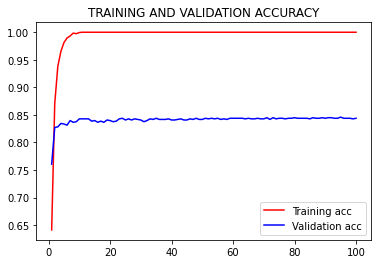

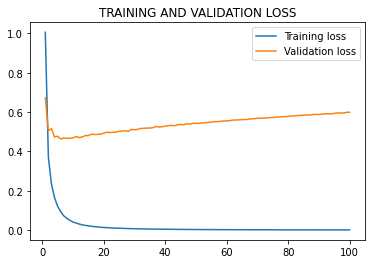

In [35]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc) + 1)

plt.plot(epochs, acc, 'r', label= 'Training acc')
plt.plot(epochs, val_acc, 'b', label= 'Validation acc')
plt.title('TRAINING AND VALIDATION ACCURACY')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label = 'Training loss')
plt.plot(epochs, val_loss, label = 'Validation loss')
plt.title('TRAINING AND VALIDATION LOSS')
plt.legend()

plt.show()

In [36]:
test_generator = valid_datagan.flow_from_directory(test_dir,
                                                target_size = (224,224),
                                                batch_size = 24,
                                                class_mode = 'categorical')
test_loss, test_acc = new_model.evaluate_generator(test_generator,steps=50)
print('test acc : ', test_acc)

Found 964 images belonging to 5 classes.


/var/folders/n_/n7h63p7n0p94s4q0cjjkgtl40000gn/T/ipykernel_1081/3651254452.py:5: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = new_model.evaluate_generator(test_generator,steps=50)
2022-05-18 11:07:56.638358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


test acc :  0.8485477566719055


In [37]:
## 첫번째 시도 모델 결과 확인
'''
resnet50 
lr : 0.01
batch : 24
epoch : 100
=> test acc :  0.63

data : 구글, 네이버 한글 검색 
'''
# 저장된 모델 불러오기
model_path = os.path.join(cur_dir, model_dir)
file_name = 'resnet50(0505)_Normal_lr0.0001_ba56_ep100.h5'
model_file = os.path.join(model_path,file_name)

new_model = keras.models.load_model(model_file)
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 resizing (Resizing)         (None, 256, 256, 3)       0         
                                                                 
 center_crop (CenterCrop)    (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                             

In [38]:
history = pickle.load(open('./save_model/resnet50(0419)_Normal_lr0.0001_ba24_ep100-history', "rb"))

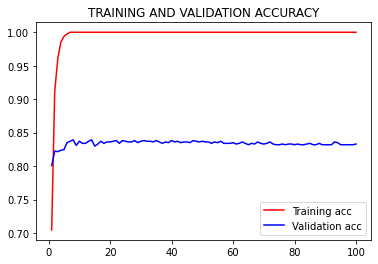

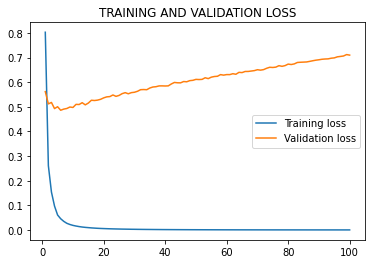

In [40]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc) + 1)

plt.plot(epochs, acc, 'r', label= 'Training acc')
plt.plot(epochs, val_acc, 'b', label= 'Validation acc')
plt.title('TRAINING AND VALIDATION ACCURACY')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label = 'Training loss')
plt.plot(epochs, val_loss, label = 'Validation loss')
plt.title('TRAINING AND VALIDATION LOSS')
plt.legend()

plt.show()

In [42]:
test_generator = valid_datagan.flow_from_directory(test_dir,
                                                target_size = (224,224),
                                                batch_size = 24,
                                                class_mode = 'categorical')

test_loss, test_acc = new_model.evaluate_generator(test_generator,steps=50)
print('test acc : ', test_acc)

Found 964 images belonging to 5 classes.


/var/folders/n_/n7h63p7n0p94s4q0cjjkgtl40000gn/T/ipykernel_1081/283583462.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = new_model.evaluate_generator(test_generator,steps=50)
2022-05-18 11:09:43.651930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


test acc :  0.8485477566719055


In [43]:
# {'geumjeonsoo': 0, 'monstera': 1, 'stuckyi': 2, 'tableyaja': 3, 'yeoincho': 4}

In [44]:
file_name = 'save_model/h5/resnet50(0419)_Normal_lr0.0001_ba24_ep100.h5'
new_model = keras.models.load_model(file_name)

In [45]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import numpy as np

In [47]:
# 테스트할 이미지 불러오기
img_height = 224
img_width = 224

label_names = {0 : 'geumjeonsoo', 1 : 'monstera',2 :'stuckyi', 3:'tableyaja', 4:'yeoincho'}

filename =  # 이미지 파일 지정
original = load_img(filename, target_size = (img_height,img_width))

numpy_image = img_to_array(original)
plt.imshow(np.uint8(numpy_image))
plt.show()
print("numpy array size : ", numpy_image.shape)
image_batch = np.expand_dims(numpy_image , axis = 0)

predict = np.argmax(new_model.predict(image_batch))

# print(predict)
print('결과 : ',label_names[predict])

SyntaxError: invalid syntax (1704051278.py, line 7)